In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv10

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [2]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**NOTE:** We will also install two additional packages: [`roboflow`](https://github.com/roboflow/roboflow-python) to download the dataset from [Roboflow Universe](https://universe.roboflow.com/), which we will use to train our model, and [`supervision`](https://github.com/roboflow/supervision), which we will use for visualizing the results.

In [3]:
!pip install -q supervision roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00


## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [4]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
# !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 11M
-rw-r--r-- 1 root root 11M May 26 15:54 yolov10n.pt


## Download dataset from Roboflow Universe

In [19]:
# Use this in a code cell in Google Colab
!rm -rf /content/datasets
!mkdir /content/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="h0LatO6wKxgJUq5K6HTI")
project = rf.workspace("tanay-bs8l1").project("adobe-gamesense")
version = project.version(1)
dataset = version.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Adobe-GameSense-1 in yolov8:: 100%|██████████| 1962/1962 [00:00<00:00, 4040.22it/s]


In [13]:
import os

# Define the paths to the directories
labels_dir = r'Adobe-GameSense-1/test/labels'
images_dir = r'Adobe-GameSense-1/test/images'

# Debug path existence
if not os.path.exists(labels_dir):
    print(f"The path {labels_dir} does not exist.")
if not os.path.exists(images_dir):
    print(f"The path {images_dir} does not exist.")

# Initialize the dictionary to store the sets
label_dict = {0: set()}

# Iterate over all the files in the labels directory
for filename in os.listdir(labels_dir):
    # Only process .txt files
    if filename.endswith('.txt'):
        filepath = os.path.join(labels_dir, filename)
        image_filepath = os.path.join(images_dir, filename.replace('.txt', '.jpg'))  # Assuming .jpg extension for images

        # Read the annotation file
        with open(filepath, 'r') as file:
            lines = file.readlines()

        # Process the lines
        new_lines = []
        for line in lines:
            elements = line.strip().split()
            if len(elements) != 5:
                print(f"Invalid number of coordinates: {len(elements)} in file {filepath}")
                continue  # Skip this line

            label = int(elements[0])
            if label not in [0, 1]:
                continue  # Skip if label is not 0 or 1

            # Replace label 1 with 0
            if label == 1:
                new_lines.append(f"0 {' '.join(elements[1:])}\n")

        # Write the new content to the file if it's not empty
        if new_lines:
            with open(filepath, 'w') as file:
                file.writelines(new_lines)
        else:
            # If file is empty after processing, delete the file and the corresponding image
            os.remove(filepath)
            print(f"Deleted file: {filepath}")
            if os.path.exists(image_filepath):
                os.remove(image_filepath)
                print(f"Deleted image: {image_filepath}")

# Print the resulting dictionary
print(label_dict)


{0: set()}


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the paths
source_dir = r"YOLOv8-DeepSORT-Object-Tracking\ultralytics\yolo\v8\detect\Adobe-GameSense-1\train\images"
dest_dir = r"YOLOv8-DeepSORT-Object-Tracking\ultralytics\yolo\v8\detect\Adobe-GameSense-1\train\preprocess_images"

# Create destination directory if it doesn't exist
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

# Process each image in the source directory
for filename in os.listdir(source_dir):
    image_path = os.path.join(source_dir, filename)

    if not os.path.isfile(image_path):
        continue

    # Read and process the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Image {filename} not loaded properly.")
        continue

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
    black_mask = cv2.bitwise_not(mask)
    black_image = np.zeros_like(image)
    colored_foreground = cv2.bitwise_and(image, image, mask=mask)
    black_background = cv2.bitwise_and(black_image, black_image, mask=black_mask)
    final_image = cv2.add(colored_foreground, black_background)

    crop_top = 100
    crop_bottom = 0
    crop_left = 200
    crop_right = 200

    h, w, _ = final_image.shape
    final_image_cropped = final_image[crop_top:h-crop_bottom, crop_left:w-crop_right]

    final_image_rgb = cv2.cvtColor(final_image_cropped, cv2.COLOR_BGR2RGB)

    # Save the processed image
    dest_path = os.path.join(dest_dir, filename)
    cv2.imwrite(dest_path, cv2.cvtColor(final_image_rgb, cv2.COLOR_RGB2BGR))

    print(f"Processed and saved: {filename}")

print("All images processed and saved.")


## Custom Training

In [17]:
%cd {HOME}

!yolo task=detect mode=train epochs=1 batch=1 plots=True \
model={HOME}/weights/yolov10n.pt \
data={dataset.location}/data.yaml

/content
/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
New h

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1716829751.122067014f9f.1155.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


/content


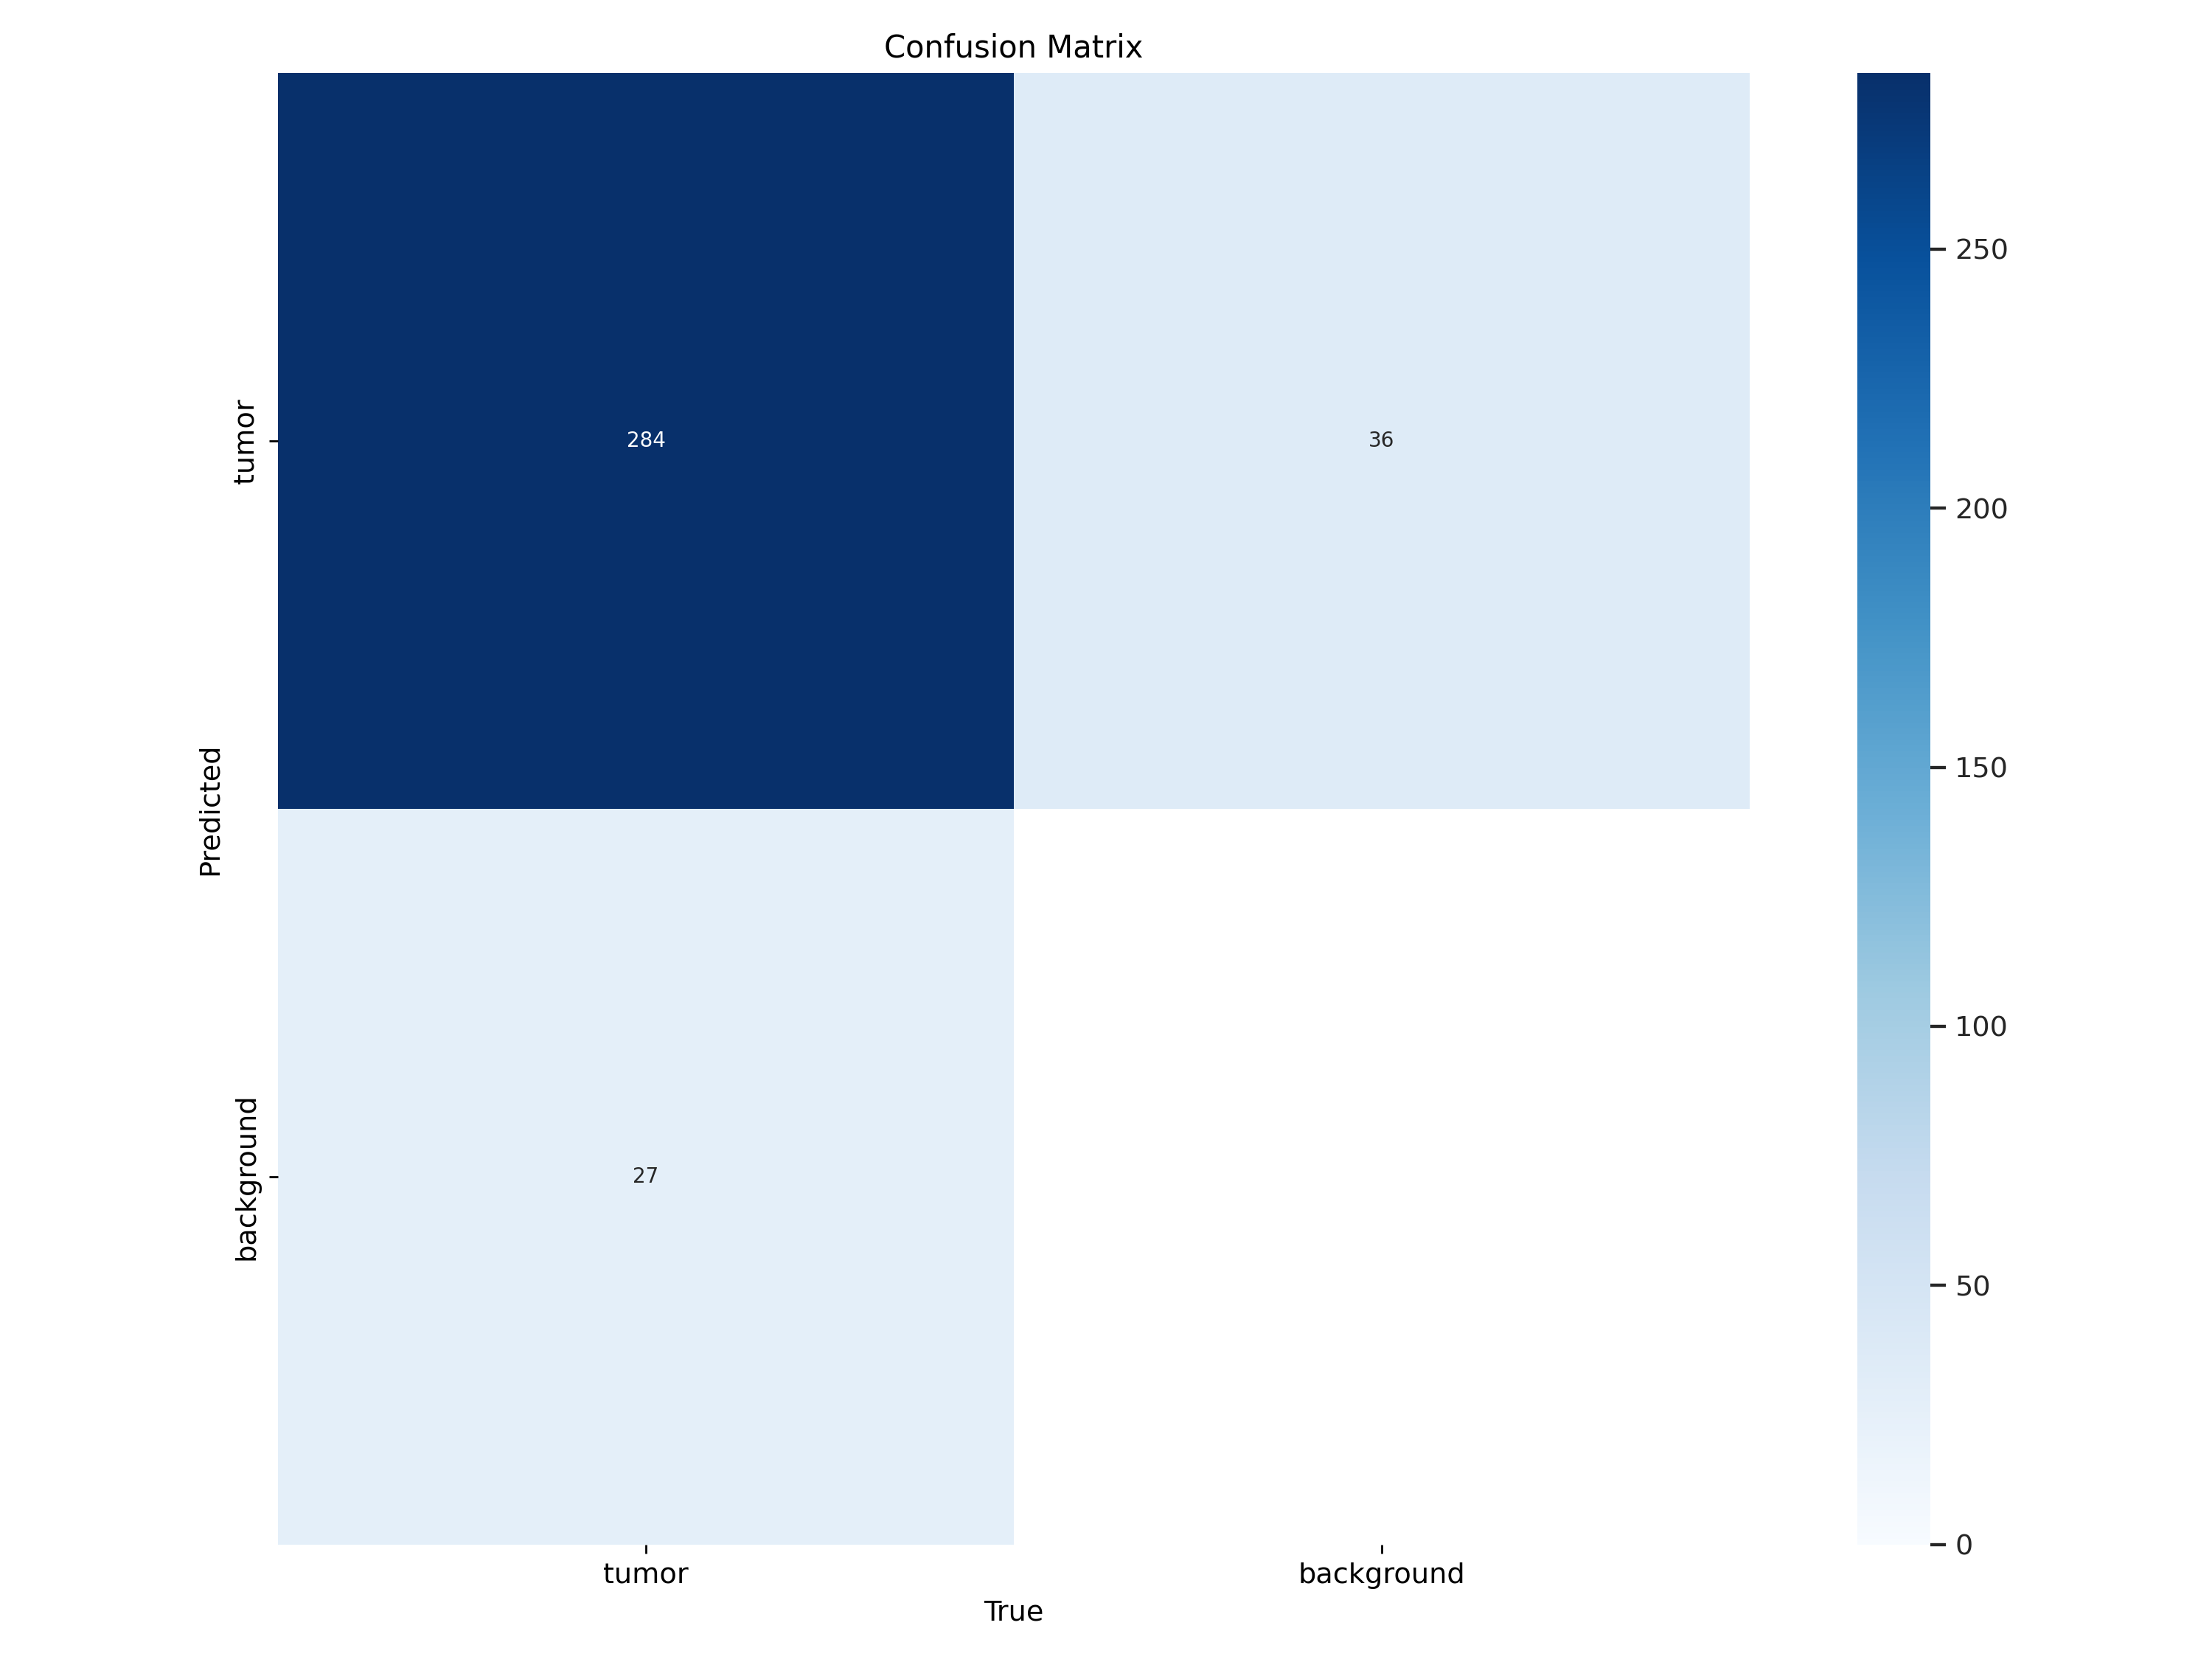

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


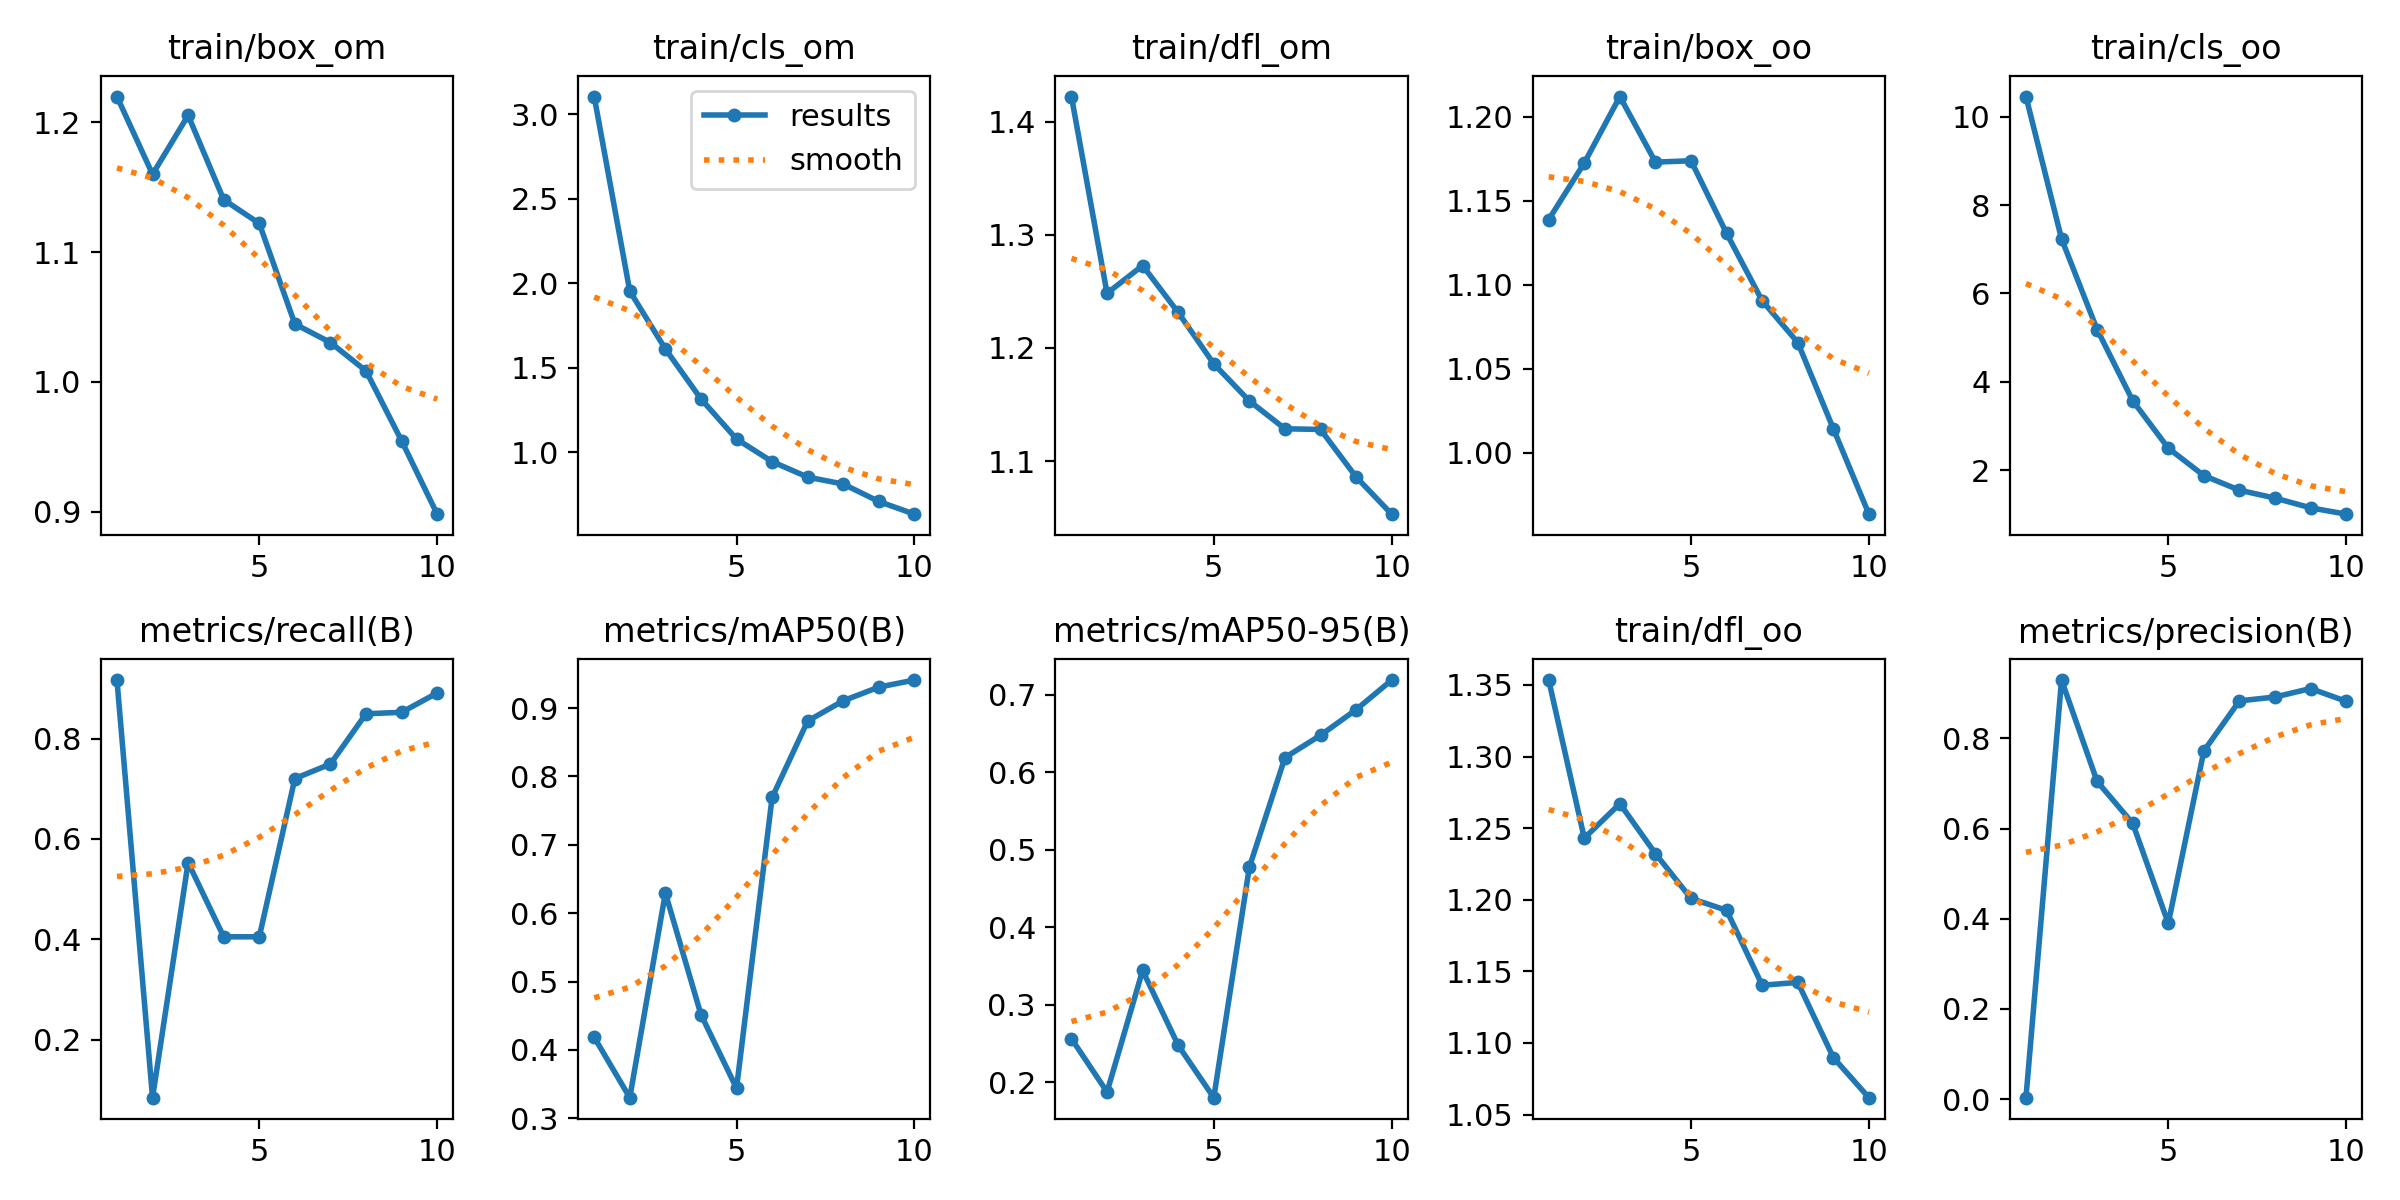

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [ ]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

**NOTE:** Let's randomly select an image from our validation set and visualize the results.


0: 640x640 1 tumor, 56.7ms
Speed: 2.0ms preprocess, 56.7ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)


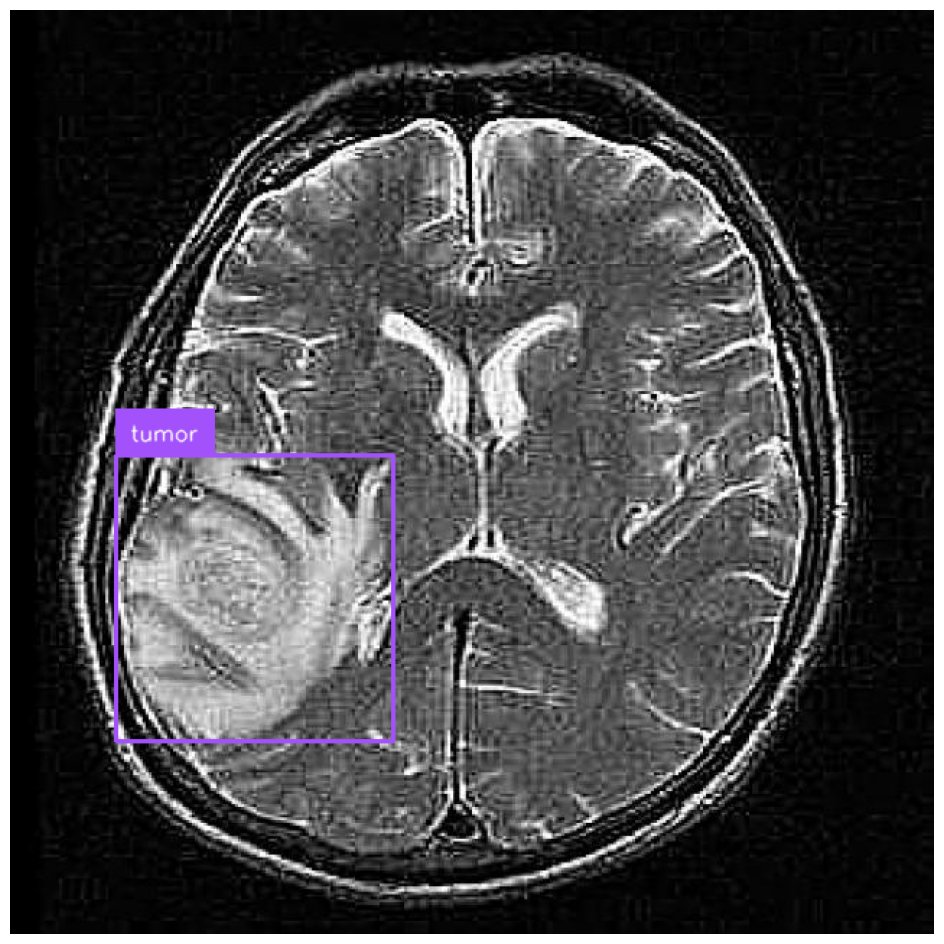

In [ ]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Deploy model on Roboflow

Once you have finished training your YOLOv10 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv8 weights.

To upload model weights, add the following code to the “Inference with Custom Model” section in the aforementioned notebook:

In [ ]:
project.version(dataset.version).deploy(model_type="yolov10", model_path=f"{HOME}/runs/detect/train/")

While your deployment is processing, checkout the deployment docs to take your model to most destinations https://docs.roboflow.com/inference